# Lab03: MLP

---
MSSV: 18120296

Họ và tên: Cao Tất Cường

## Import

In [1]:
%matplotlib inline
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cPickle

# ignore warning ...
import warnings
import math
warnings.filterwarnings('ignore')

## Định nghĩa các hàm
**Hàm đọc bộ dữ liệu CIFAR-10**

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    #dict = cPickle.load( CIFAR-10
    # Modified
    dict = cPickle.load(fo, encoding='latin1')
    return dict
def read_data(containing_dir, num_train_batchs):
    # Read training data
    train_X_batchs = []
    train_Y_batchs = []
    for batch_idx in range(num_train_batchs):
        batch = unpickle(containing_dir + '\\data_batch_' + str(batch_idx + 1))
        train_X_batchs.append(batch['data'])
        train_Y_batchs.append(np.array(batch['labels']).reshape(-1, 1))
    train_X = np.vstack(train_X_batchs)
    train_X = train_X / 255. # Normalize to [0, 1]
    train_X = np.hstack([np.ones((len(train_X), 1)), train_X])
    train_Y = np.vstack(train_Y_batchs)
    
    # Read test data
    batch = unpickle(containing_dir + '\\test_batch')
    test_X = batch['data']
    test_X = test_X / 255. # Normalize to [0, 1]
    test_X = np.hstack([np.ones((len(test_X), 1)), test_X])
    test_Y = np.array(batch['labels']).reshape(-1, 1)
    
    return (train_X, train_Y, test_X, test_Y)

**Hàm tính output và gradient của Neural Net**

Ở đây, ta dùng hàm kích hoạt sigmoid ở các tầng ẩn, và hàm softmax ở tầng cuối.
Ta có:

$$ h=w^TX $$

$$\text{Sigmoid Activation: } z= \sigma \left(h\right)= \dfrac{1}{1+e^{-h}}$$

$$\text{Cross-entrophy loss: } J(w)=-\left({ylog(z)+(1-y)log(1-z)}\right)$$

$$\text{Chain rule: } \dfrac{\partial J(w)}{\partial w}=\dfrac{\partial J(w)}{\partial z} \dfrac{\partial z}{\partial h}\dfrac{\partial h}{\partial w}  $$

$$\dfrac{\partial J(w)}{\partial z}=-\left(\dfrac{y}{z}-\dfrac{1-y}{1-z}\right)=\dfrac{z-y}{z(1-z)}$$

$$\dfrac{\partial z}{\partial h}=z(1-z)$$

$$\dfrac{\partial h}{\partial w}=X$$

$$\dfrac{\partial J(w)}{\partial w}=X^T(z-y)$$

**Hàm cost và gradient tầng sigmoid:**
$$J(w)=\dfrac{1}{N} \sum_{n=1}^N-\left({ylog(z)+(1-y)log(1-z)}\right)  $$
$$\text{Gradient: } \dfrac{\partial J(w)}{\partial w}=\dfrac{1}{N}X^T(z-y)$$  

Hàm softmax (C là số lớp): 
$$h(z_i)=\dfrac{e^{z_i}}{\sum_{j=1}^{C}e^{z_j}}$$
**Hàm cost tầng softmax lúc này là:**
$$J(w)=\dfrac{1}{N} \sum_{n=1}^N \sum_{k=1}^K -(y_n)_k log \left(h(x_n)_k\right)  $$

Sử dụng kỹ thuật one-hot-encoding mã hóa tập label y, ta có:
 $$\text{với } (y_n)_k=    \begin{align}
        \begin{cases}
             0 \text { nếu } y_n\neq k\\
             1 \text { nếu } y_n= k\\
        \end{cases}
    \end{align} $$
lúc này số lớp sẽ là 2 hay C=2:

$$h(z_1)=\dfrac{e^{z_1}}{\sum_{j=1}^{2}e^{z_j}}$$

$$h(z_1)=\dfrac{e^{z_1}}{e^{z_1}+e^{z_2}}$$

$$h(z_1)=\dfrac{1}{1+e^{z_2-z_1}}$$

=> Đây chính là hàm sigmoid. Hơn nữa mặc dù có 2 output softmax vẫn có thể rút gọn thành 1 output vì tổng 2 outputs luôn bằng 1

**Do đó hàm cost của tầng softmax và tầng sigmoid là tương tự nhau** 

**=> Gradient của tầng softmax cũng tương tự của tầng sigmoid**

In [3]:

def sigmoid(x):
    '''
    Computes sigmoid function for each element of array S.
    '''
    return 1 / (1 + np.exp(-x))



def gradient_sigmoid(As, Ws ,mb_X,delta, i):
    '''
    Computes gradient vector for sigmoid layer.
    '''
    temp = delta.copy()
    delta = []
    grad = []
    for j in range(i, 0, -1):
        temp = np.multiply(np.dot(temp, Ws[j].T), As[j] - np.power(As[j],2))
        temp = temp[:,1:]
        delta.append(temp)
        grad.append(np.dot(As[j-1].T,temp) / len(As[j-1]))
    return delta, grad


def softmax(S):
    '''
    Computes softmax function for each row of array S.
    '''
    A = np.exp(S)
    A /=A.sum(axis=1, keepdims=True)

    return A

def gradient_softmax(As,mb_X,mb_Y):
    '''
    Computes gradient vector for softmaz layer
    '''
    delta = As[-1] - mb_Y
    grad = np.dot(As[-2].T, delta)/ len(mb_X)
    return delta, grad

def compute_nnet_outputs(Ws, X, need_all_layer_outputs):
    '''
    Computes the outputs of Neural Net by forward propagating X through the net.
    '''
    num_layers = len(Ws)
    As = [X]
    a_1 = X
    for i in range(num_layers - 1):
        z = np.dot(a_1, Ws[i])  
        a = sigmoid(z)
        a = np.append(np.ones((a.shape[0], 1)), a, axis=1)
        As.append(a)
        a_1 = a
    z_last = np.dot(As[-1], Ws[-1])
    a_last = softmax(z_last)
    As.append(a_last)
    if need_all_layer_outputs:
        return As
    else:
        A = As[-1]
        return A

**Các hàm khởi tạo tham số**

In [4]:

def compute_layer_sizes(X, Y, hid_layer_sizes):
    num_classes = len(np.unique(Y)) # Num classes
    layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [num_classes]
    print('Layer Sizes: ',layer_sizes)
    return layer_sizes


def one_hot_encoding(Y, num_classes):
    num_classes = len(np.unique(Y)) # Num classes
    one_hot_Y = np.zeros((len(Y), num_classes))
    one_hot_Y[np.arange(len(Y)), Y.reshape(-1)] = 1
    return one_hot_Y


def init_weight_matrix(X,Y,layer_sizes):
    #fix random for same result when init weight matrix
    np.random.seed(0) 
    Ws = np.array([np.random.randn(layer_sizes[i]+1 , layer_sizes[i + 1]) / np.sqrt(layer_sizes[i]+1) 
          for i in range(len(layer_sizes) - 1)]) # Init Ws
    print('Weight matrix shape: ',Ws[0].shape,Ws[1].shape)
    return Ws




**Hàm huấn luyện Neural net**

In [5]:

def updateWeights(Ws,As,mb_X, mb_Y,  learning_rate):
    #update weights for softmax layer
    num_hidden_layer = len(Ws) - 1
    delta_last , grad_last = gradient_softmax(As,mb_X,mb_Y)
    delta , grad = gradient_sigmoid(As, Ws ,mb_X,delta_last, num_hidden_layer)
    Ws[-1] = Ws[-1] - learning_rate * grad_last
    #update weights for hidden layer
    grad = grad[::-1]
    for i in range(len(delta)):
        Ws[i] = Ws[i] - learning_rate * grad[i]
    return Ws

def train_nnet(X, Y, hid_layer_sizes, mb_size, learning_rate, max_epoch):
    
    #get layer sizes:
    layer_sizes = compute_layer_sizes(X, Y, hid_layer_sizes)

    
    # Prepare for training
    Ws=init_weight_matrix(X,Y,layer_sizes)
    one_hot_Y=one_hot_encoding(Y,layer_sizes[-1])
    
    costs = [] # To save costs during training
    errs = [] # To save mean binary errors during training
    N = len(X) # Num training examples
    rnd_idxs = list(range(N)) # Random indexes    
    
    # Train
    for epoch in list(range(max_epoch)):
        #shuffle index
        np.random.shuffle(rnd_idxs)
        for start_idx in list(range(0, N, mb_size)):
            # Get minibach
            mb_X = X[rnd_idxs[start_idx:start_idx+mb_size]]
            mb_Y = one_hot_Y[rnd_idxs[start_idx:start_idx+mb_size]]
            
            # Forward-prop
            As = compute_nnet_outputs(Ws, mb_X, True)
            
            # Back-prop; on the way, compute each layer's gradient and update its W
            Ws=updateWeights(Ws,As,mb_X,mb_Y,learning_rate)   

        
        # Compute training info, save it, and print it
        A = compute_nnet_outputs(Ws, X, False)
        cost = np.mean(-np.sum(one_hot_Y * np.log(A), axis=1))
        err = np.mean(np.argmax(A, axis=1) != Y.squeeze()) * 100
        costs.append(cost)
        errs.append(err)
        print ('Epoch %d, cost %.3f, err %.3f%%' %(epoch, cost, err))
            
    return Ws, costs, errs

## Chạy

**1.** Đọc dữ liệu (cần đặt thư mục chứa dữ liệu `cifar-10-batches-py` vào cùng thư mục chứa file notebook này)

In [6]:
num_train_batchs = 3 
train_X, train_Y, test_X, test_Y = read_data('cifar-10-batches-py', num_train_batchs)
print ('train_X.shape = %s, train_Y.shape = %s' %(train_X.shape, train_Y.shape))
print ('test_X.shape  = %s, test_Y.shape  = %s' %(test_X.shape, test_Y.shape))

train_X.shape = (30000, 3073), train_Y.shape = (30000, 1)
test_X.shape  = (10000, 3073), test_Y.shape  = (10000, 1)


**2.** Để thấy được sự ảnh hưởng của số lượng nơ-ron ẩn, ta sẽ lần lượt huấn luyện Neural Net với `hid_layer_sizes = [50]`, `[100]`, và `[200]` (cố định `mb_size = 32`, `learning_rate = 0.01`, `max_epoch = 200`)

In [7]:
W_0, costs_0, errs_0 = train_nnet(train_X, train_Y, [50], 32, 0.01, 200)

Layer Sizes:  [3072, 50, 10]
Weight matrix shape:  (3073, 50) (51, 10)
Epoch 0, cost 2.058, err 71.200%
Epoch 1, cost 1.955, err 67.930%
Epoch 2, cost 1.899, err 65.573%
Epoch 3, cost 1.868, err 65.867%
Epoch 4, cost 1.834, err 63.573%
Epoch 5, cost 1.819, err 63.860%
Epoch 6, cost 1.796, err 62.440%
Epoch 7, cost 1.779, err 62.133%
Epoch 8, cost 1.771, err 61.657%
Epoch 9, cost 1.757, err 61.437%
Epoch 10, cost 1.741, err 60.683%
Epoch 11, cost 1.733, err 60.667%
Epoch 12, cost 1.718, err 59.677%
Epoch 13, cost 1.712, err 59.673%
Epoch 14, cost 1.717, err 60.073%
Epoch 15, cost 1.692, err 59.100%
Epoch 16, cost 1.705, err 59.550%
Epoch 17, cost 1.680, err 58.970%
Epoch 18, cost 1.668, err 58.163%
Epoch 19, cost 1.663, err 58.060%
Epoch 20, cost 1.659, err 57.673%
Epoch 21, cost 1.639, err 56.953%
Epoch 22, cost 1.630, err 56.547%
Epoch 23, cost 1.629, err 57.050%
Epoch 24, cost 1.615, err 56.567%
Epoch 25, cost 1.612, err 56.543%
Epoch 26, cost 1.603, err 56.063%
Epoch 27, cost 1.600,

In [8]:
W_1, costs_1, errs_1 = train_nnet(train_X, train_Y, [100], 32, 0.01, 200)

Layer Sizes:  [3072, 100, 10]
Weight matrix shape:  (3073, 100) (101, 10)
Epoch 0, cost 2.048, err 70.893%
Epoch 1, cost 1.941, err 66.473%
Epoch 2, cost 1.886, err 65.187%
Epoch 3, cost 1.856, err 64.873%
Epoch 4, cost 1.825, err 63.030%
Epoch 5, cost 1.807, err 62.657%
Epoch 6, cost 1.793, err 62.457%
Epoch 7, cost 1.782, err 62.280%
Epoch 8, cost 1.765, err 61.783%
Epoch 9, cost 1.758, err 61.513%
Epoch 10, cost 1.745, err 61.247%
Epoch 11, cost 1.732, err 60.167%
Epoch 12, cost 1.720, err 59.347%
Epoch 13, cost 1.714, err 60.003%
Epoch 14, cost 1.711, err 59.837%
Epoch 15, cost 1.689, err 58.557%
Epoch 16, cost 1.687, err 58.370%
Epoch 17, cost 1.679, err 59.200%
Epoch 18, cost 1.658, err 57.557%
Epoch 19, cost 1.650, err 57.260%
Epoch 20, cost 1.644, err 57.587%
Epoch 21, cost 1.642, err 56.920%
Epoch 22, cost 1.632, err 56.710%
Epoch 23, cost 1.625, err 56.553%
Epoch 24, cost 1.615, err 56.393%
Epoch 25, cost 1.615, err 56.227%
Epoch 26, cost 1.600, err 55.663%
Epoch 27, cost 1.5

In [9]:
W_2, costs_2, errs_2 = train_nnet(train_X, train_Y, [200], 32, 0.01, 200)

Layer Sizes:  [3072, 200, 10]
Weight matrix shape:  (3073, 200) (201, 10)
Epoch 0, cost 2.029, err 72.163%
Epoch 1, cost 1.931, err 68.460%
Epoch 2, cost 1.881, err 65.900%
Epoch 3, cost 1.848, err 64.187%
Epoch 4, cost 1.831, err 64.510%
Epoch 5, cost 1.810, err 63.197%
Epoch 6, cost 1.785, err 61.640%
Epoch 7, cost 1.776, err 61.803%
Epoch 8, cost 1.769, err 61.593%
Epoch 9, cost 1.763, err 60.840%
Epoch 10, cost 1.743, err 60.477%
Epoch 11, cost 1.749, err 61.957%
Epoch 12, cost 1.724, err 59.600%
Epoch 13, cost 1.720, err 59.800%
Epoch 14, cost 1.707, err 58.763%
Epoch 15, cost 1.702, err 58.683%
Epoch 16, cost 1.698, err 59.103%
Epoch 17, cost 1.687, err 58.577%
Epoch 18, cost 1.677, err 58.143%
Epoch 19, cost 1.665, err 57.567%
Epoch 20, cost 1.658, err 57.320%
Epoch 21, cost 1.650, err 57.097%
Epoch 22, cost 1.653, err 57.920%
Epoch 23, cost 1.649, err 57.737%
Epoch 24, cost 1.620, err 56.270%
Epoch 25, cost 1.612, err 55.943%
Epoch 26, cost 1.608, err 55.840%
Epoch 27, cost 1.6

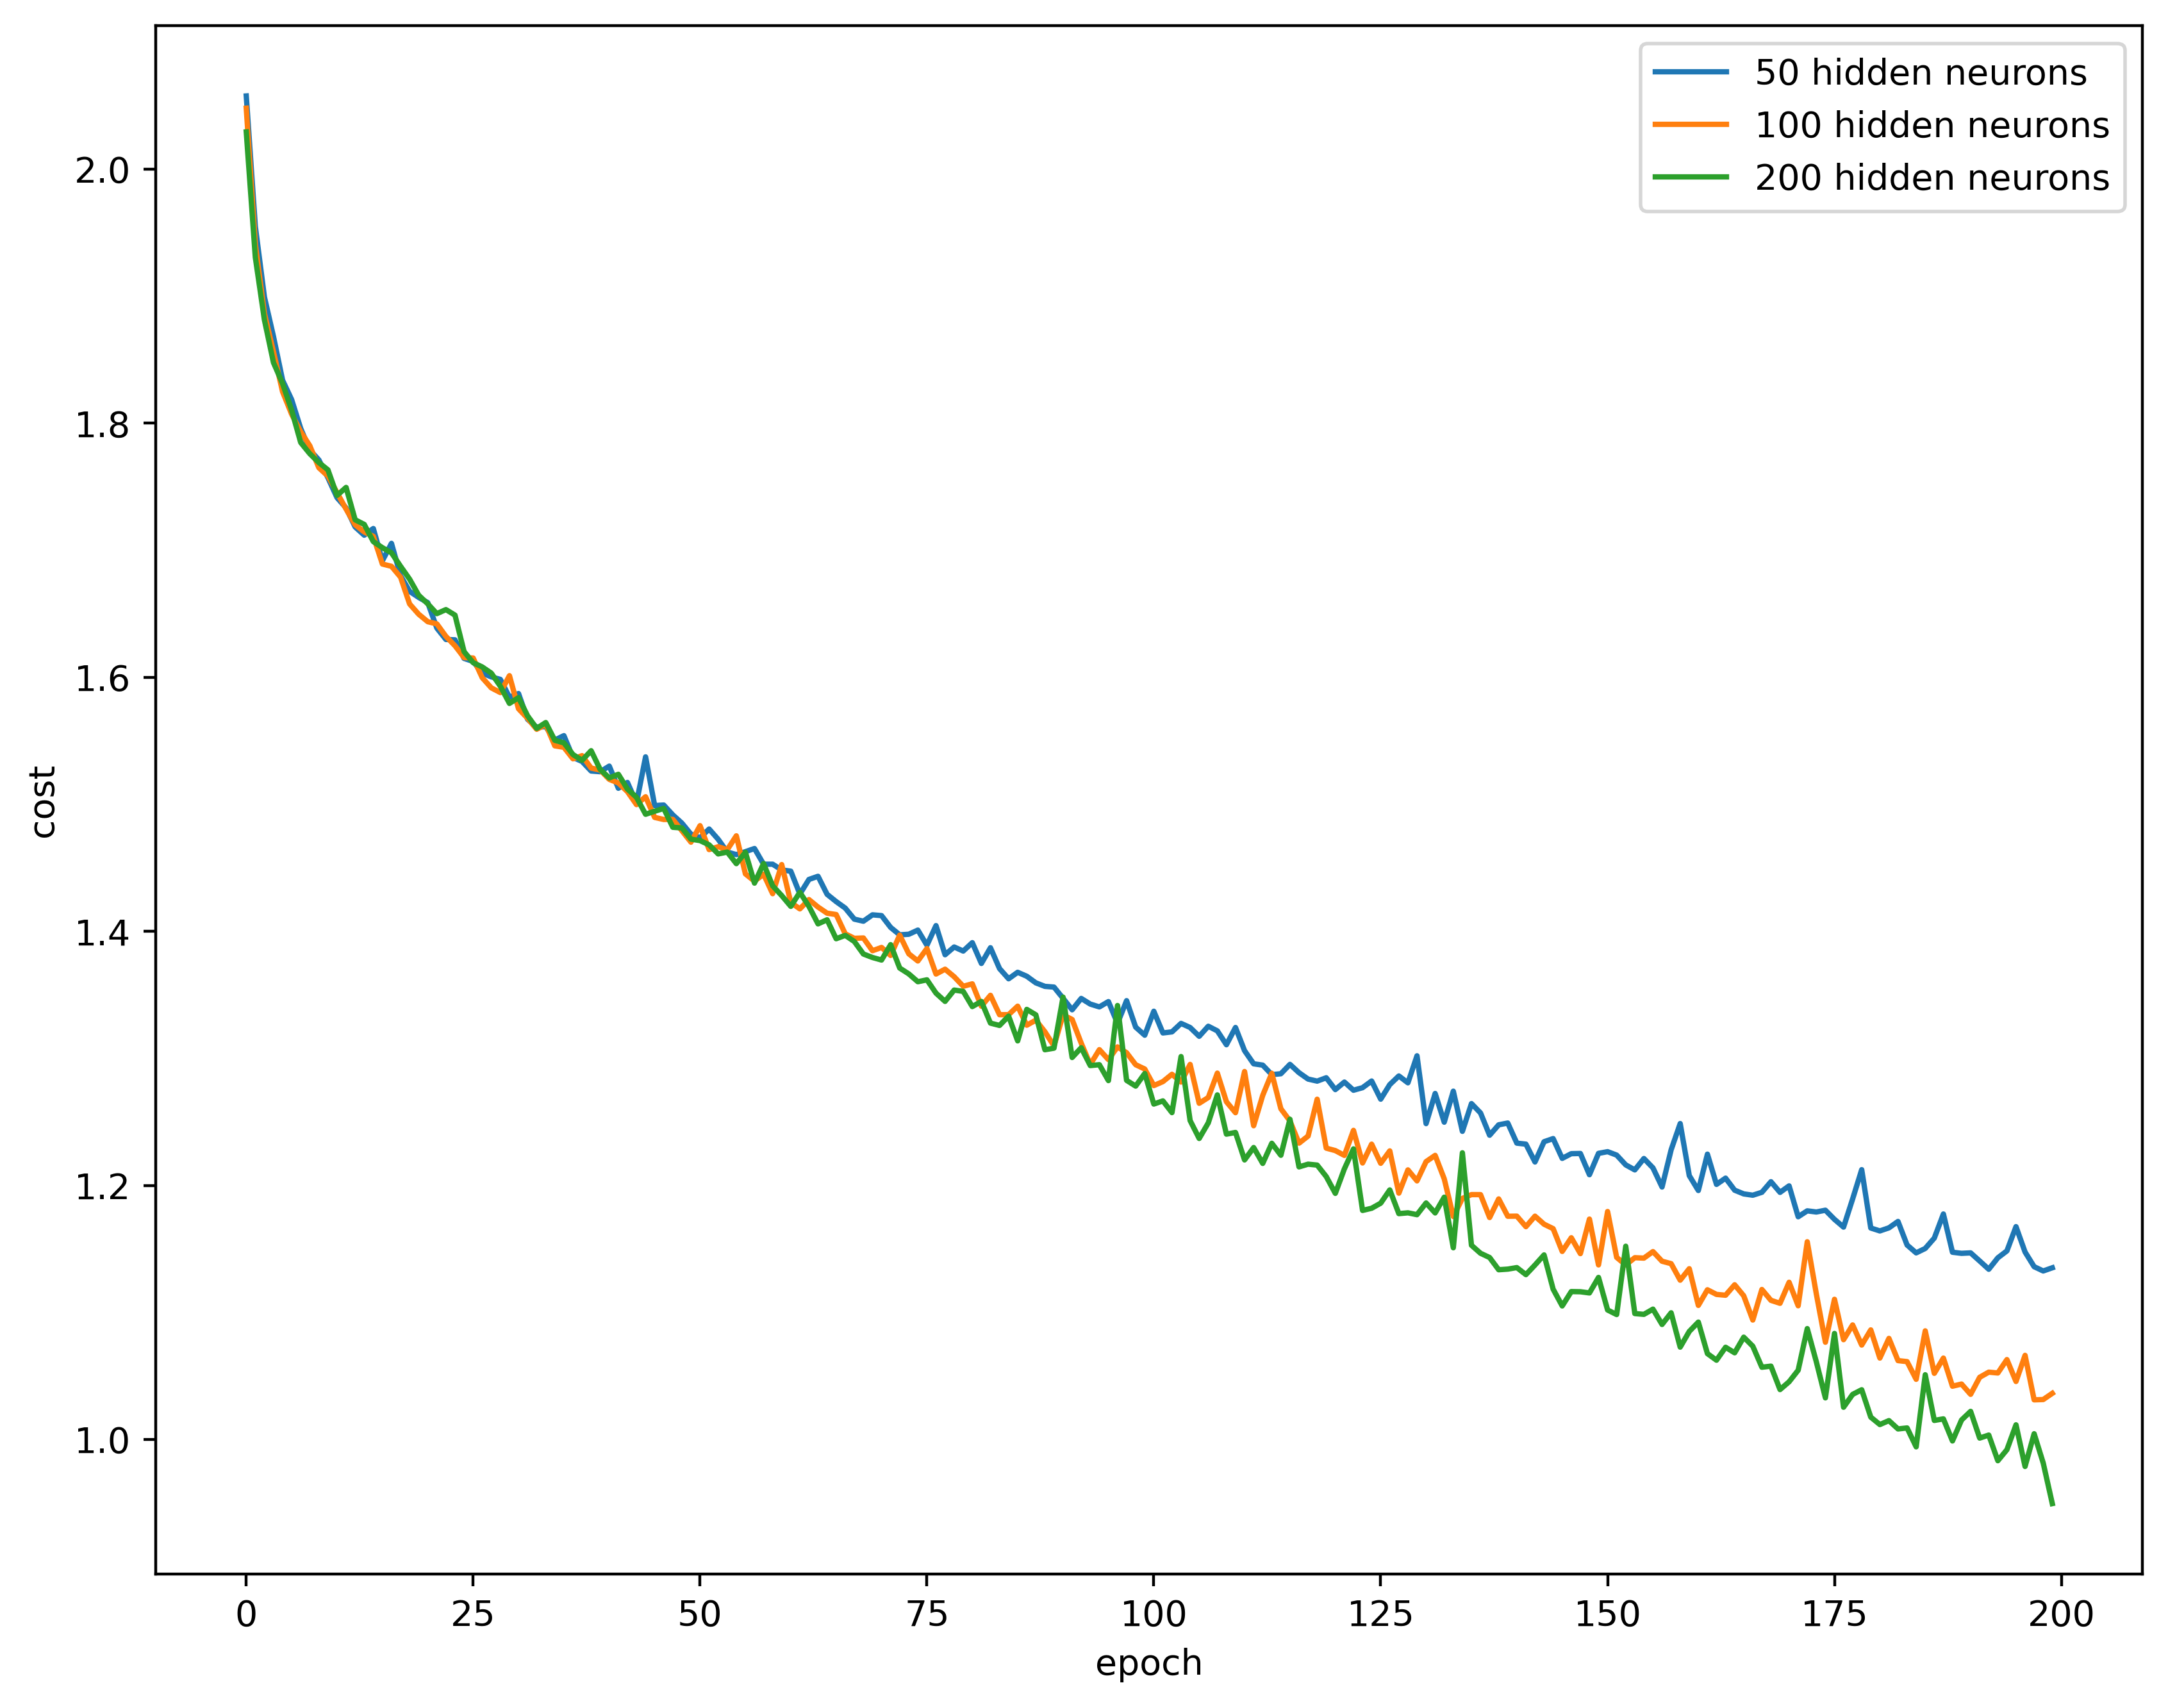

In [10]:
# Visualize results
epochs = np.arange(len(costs_0))
plt.figure(figsize=(10,8),dpi=400)
plt.plot(epochs, costs_0, label='50 hidden neurons')
plt.plot(epochs, costs_1, label='100 hidden neurons')
plt.plot(epochs, costs_2, label='200 hidden neurons')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend(loc='best')
plt.savefig('figure_1.png')

Đánh giá mô  hình
+ Với số lượng epoch nhỏ, dường như không có sự khác biệt trong cost giữa 50,100 hay 200 neurons. Tuy nhiên khi tăng số epoch lên, ta nhận thấy, càng tăng epoch tốc độ giảm cost của số lượng các neuron càng khác nhau, số neuron càng lớn tốc độ giảm cost càng nhanh.
+ Từ đây ta có thể rút ra được kết luận rằng: Khi tăng số lượng neuron trong neural network, cần chú ý đến số lần epoch. Bởi chỉ khi số lượng epoch đạt một ngưỡng nhất định, sự khác biệt trong cost giữa số lượng neuron mới thể hiện rõ rệt. Vì thế, cần chú ý đến các yếu tố thời gian và computing power để kết quả đạt tối ưu.